# Cluster Analysis, ANN, & Text Mining: Part 1 - Clustering
This section will cover part 1 of the rubric, which includes K-means clustering and Hierarchical clustering.

## K-Means Clustering
We'll use K-Means clustering to group movies by similar IMDB rating, critics' score, and audience rating.

### Read Dataset
First, we need to load the csv dataset into a python dataframe.

In [1]:
import pandas as pd

df = pd.read_csv('../imdb_dataset.csv')
df.head()

,Unnamed: 0,title,title_type,genre,runtime,mpaa_rating,studio,thtr_rel_year,thtr_rel_month,thtr_rel_day,...,best_dir_win,top200_box,director,actor1,actor2,actor3,actor4,actor5,imdb_url,rt_url
0,1,Filly Brown,Feature Film,Drama,80.0,R,Indomina Media Inc.,2013,4,19,...,no,no,Michael D. Olmos,Gina Rodriguez,Jenni Rivera,Lou Diamond Phillips,Emilio Rivera,Joseph Julian Soria,http://www.imdb.com/title/tt1869425/,//www.rottentomatoes.com/m/filly_brown_2012/
1,2,The Dish,Feature Film,Drama,101.0,PG-13,Warner Bros. Pictures,2001,3,14,...,no,no,Rob Sitch,Sam Neill,Kevin Harrington,Patrick Warburton,Tom Long,Genevieve Mooy,http://www.imdb.com/title/tt0205873/,//www.rottentomatoes.com/m/dish/
2,3,Waiting for Guffman,Feature Film,Comedy,84.0,R,Sony Pictures Classics,1996,8,21,...,no,no,Christopher Guest,Christopher Guest,Catherine O'Hara,Parker Posey,Eugene Levy,Bob Balaban,http://www.imdb.com/title/tt0118111/,//www.rottentomatoes.com/m/waiting_for_guffman/
3,4,The Age of Innocence,Feature Film,Drama,139.0,PG,Columbia Pictures,1993,10,1,...,yes,no,Martin Scorsese,Daniel Day-Lewis,Michelle Pfeiffer,Winona Ryder,Richard E. Grant,Alec McCowen,http://www.imdb.com/title/tt0106226/,//www.rottentomatoes.com/m/age_of_innocence/
4,5,Malevolence,Feature Film,Horror,90.0,R,Anchor Bay Entertainment,2004,9,10,...,no,no,Stevan Mena,Samantha Dark,R. Brandon Johnson,Brandon Johnson,Heather Magee,Richard Glover,http://www.imdb.com/title/tt0388230/,//www.rottentomatoes.com/m/10004684-malevolence/


### Train & Test Split

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = '2'

In [3]:
from sklearn import cluster
from sklearn.model_selection import train_test_split

data = df.dropna()

X_train, X_test, y_train, y_test = train_test_split(data, data.title, test_size=0.2, random_state=42)

# Creating new DataFrames for training and testing sets
train_df = pd.DataFrame(X_train, columns=data.columns)
test_df = pd.DataFrame(X_test, columns=data.columns)

train_data = train_df[['imdb_rating', 'critics_score', 'audience_score']]
test_data = test_df[['imdb_rating', 'critics_score', 'audience_score']]

k_means = cluster.KMeans(n_clusters=2, max_iter=50, random_state=1)
k_means.fit(train_data) 
labels = k_means.labels_
pd.DataFrame(labels, index=train_df['title'], columns=['Cluster ID'])

,Cluster ID
title,
Cold Creek Manor,1
Memento,0
Where the Heart Is,1
Amityville II: The Possession,1
Flesh And Bone,0
...,...
Rock 'n' Roll High School,0
Django Unchained,0
Good Boy!,1


### Centroid

In [4]:
centroids = k_means.cluster_centers_
pd.DataFrame(centroids,columns=train_data.columns)

,imdb_rating,critics_score,audience_score
0,7.102837,78.578014,73.677305
1,5.631455,29.018779,46.380282


### Testing Data

In [5]:
import numpy as np

labels = k_means.predict(test_data)
labels = labels.reshape(-1, 1)

movie_titles = np.array(test_df.title).reshape(-1, 1)

new_data = np.concatenate((movie_titles, test_data, labels), axis=1)

cols = test_data.columns.tolist() + ['Cluster ID']
new_data = pd.DataFrame(new_data, columns=['title'] + cols)

new_data.head()

,title,imdb_rating,critics_score,audience_score,Cluster ID
0,Seven Pounds,7.7,27.0,75.0,1
1,Saving Face,7.6,87.0,88.0,0
2,Warrior,8.2,82.0,92.0,0
3,The Sure Thing,7.0,87.0,79.0,0
4,Held Up,5.1,17.0,43.0,1


### Elbow Method

Text(0, 0.5, 'SSE')

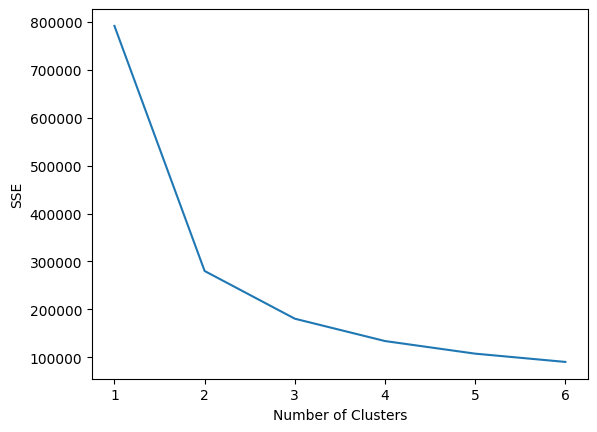

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

data = df[['imdb_rating', 'critics_score', 'audience_score']]

numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(data)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')